# Trader Behavior Insights under Market Sentiment

**Candidate:** Prathamesh Kale  
**Role:** Junior Data Scientist  

This project explores how market sentiment (Fear & Greed Index) influences trader behavior
and performance using historical trading data.


## Environment Setup

All required dependencies are listed in `requirements.txt`.

This notebook assumes a standard Python environment with:
- pandas
- numpy
- matplotlib
- seaborn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


## 1. Data Loading


In [6]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trader_df = pd.read_csv("historical_data.csv")

sentiment_df.head(), trader_df.head()


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

## 2. Initial Data Inspection


In [7]:
sentiment_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 62.0+ KB


In [8]:
trader_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

# Sentiment Distribution (categorical )

In [11]:
sentiment_df['classification'].value_counts()

classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

=> markets spend more time in fear than greed, suggesting higher volatility and emotional trading behavior.

# Sentiment Distribution (numerical) 

In [12]:
sentiment_df['value'].describe()

count    2644.000000
mean       46.981089
std        21.827680
min         5.000000
25%        28.000000
50%        46.000000
75%        66.000000
max        95.000000
Name: value, dtype: float64

=> Mean ≈ Median → distribution is fairly balanced
   Very low values (5) → extreme fear
   Very high values (95) → extreme greed
   The Fear & Greed Index shows high variability, indicating frequent emotional swings in the market.

# Closed PnL Distribution

In [13]:
trader_df['Closed PnL'].describe()


count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: Closed PnL, dtype: float64

=> 1️. Distribution is highly skewed
          Median = 0 → most trades break even
          25th percentile = 0 → a lot of zero PnL trades
          Mean = 48.75 → some big winners pull the average up
          Max = 135k, Min = -118k → huge outliers exist
      
   2. Standard deviation is huge
          Std = 919 → huge variability compared to mean
          Confirms trading outcomes are very dispersed
      
   3. Implication for analysis
          Using raw Closed PnL might be tricky
          Use median or mean per day / per trader
          Consider log-transform or capping outliers if needed

## 3. Data Cleaning & Preparation


In [9]:
# Convert timestamps
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
trader_df['Timestamp IST'] = pd.to_datetime(
    trader_df['Timestamp IST'],
    format="%d-%m-%Y %H:%M"
)

# Extract date for merging
trader_df['date'] = trader_df['Timestamp IST'].dt.date
sentiment_df['date'] = sentiment_df['date'].dt.date


##  Exploratory Data Analysis (EDA)


## 4. Merging Trader Data with Market Sentiment


In [10]:
sentiment_small = sentiment_df[['date', 'value', 'classification']]

merged_df = trader_df.merge(
    sentiment_small,
    on='date',
    how='left'
)

merged_df['value'].isna().sum()


np.int64(6)

# Drop the missing values 

In [14]:
merged_df = merged_df.dropna(subset=['value'])
merged_df['value'].isna().sum()

np.int64(0)

## 5. Market Sentiment vs Trader Performance


In [15]:
performance_summary = (
    merged_df
    .groupby('classification')['Closed PnL']
    .agg(['count', 'mean', 'median', 'sum'])
)

performance_summary


,count,mean,median,sum
classification,,,,
Extreme Fear,21400,34.537862,0.0,7.391102e+05
Extreme Greed,39992,67.892861,0.0,2.715171e+06
Fear,61837,54.290400,0.0,3.357155e+06
Greed,50303,42.743559,0.0,2.150129e+06
Neutral,37686,34.307718,0.0,1.292921e+06


=> Extreme Greed is where traders earn more.

# Visualization (Mean PnL)

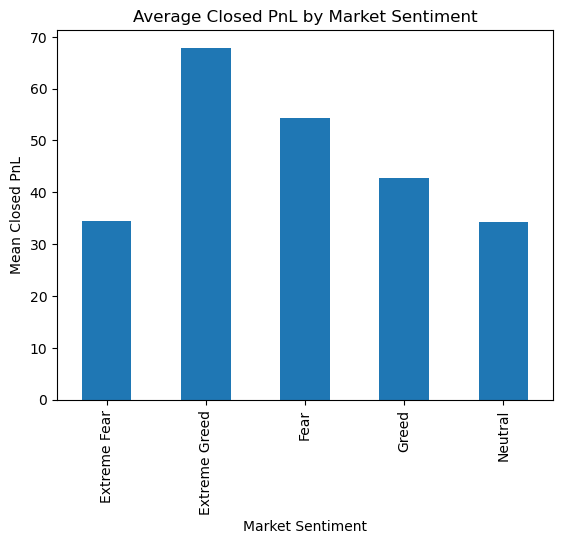

In [16]:
performance_summary['mean'].plot(
    kind='bar',
    title='Average Closed PnL by Market Sentiment',
    ylabel='Mean Closed PnL',
    xlabel='Market Sentiment'
)
plt.show()


## 6. Numeric Relationship: Sentiment Strength vs PnL


# Spearman Correlation - (as data is..)

In [17]:
merged_df[['value', 'Closed PnL']].corr(method='spearman')


,value,Closed PnL
value,1.000000,0.034938
Closed PnL,0.034938,1.000000


# Visualization (Sentiment vs Closed PnL)

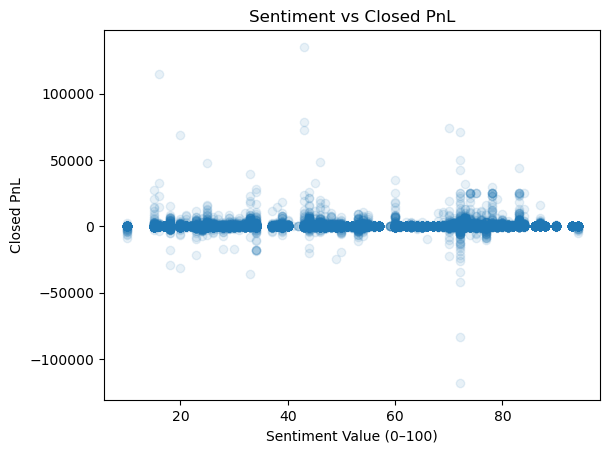

In [18]:
plt.scatter(merged_df['value'], merged_df['Closed PnL'], alpha=0.1)
plt.xlabel('Sentiment Value (0–100)')
plt.ylabel('Closed PnL')
plt.title('Sentiment vs Closed PnL')
plt.show()

## 7. Trade Size Analysis by Sentiment


In [20]:
merged_df.groupby('classification')['Size USD'].agg(['mean', 'median'])


,mean,median
classification,,
Extreme Fear,5349.731843,766.150
Extreme Greed,3112.251565,500.050
Fear,7816.109931,735.960
Greed,5736.884375,555.000
Neutral,4782.732661,547.655


During Fear phases:
a few aggressive traders deploy very large positions, possibly engaging in contrarian or mean-reversion strategies.

Lowest mean and median during Extreme Greed
Suggests:
Traders may scale down risk or market participation becomes more cautious at sentiment extremes.

While median position sizes remain relatively stable across sentiment regimes, mean position sizes peak during Fear, driven by a small subset of high-risk trades. 

This suggests that aggressive traders selectively increase exposure during fearful markets, while position sizing becomes more conservative during Extreme Greed.

## 8. Market Sentiment → Trader Behavior


In [19]:
pd.crosstab(
    merged_df['classification'],
    merged_df['Side'],
    normalize='index'
)


Side,BUY,SELL
classification,,
Extreme Fear,0.510981,0.489019
Extreme Greed,0.448590,0.551410
Fear,0.489513,0.510487
Greed,0.488559,0.511441
Neutral,0.503343,0.496657


Key observation 1 — Neutral market = balanced behavior
Neutral sentiment ≈ 50/50 Buy–Sell When sentiment is neutral, traders show no strong directional bias.

Key observation 2 — Extreme Greed shows SELL dominance 
Extreme Greed: SELL ≈ 55% BUY ≈ 45%

Traders may be:
Taking profits Fading overbought conditions Hedging risk during euphoric markets

Key observation 3 — Fear ≠ panic selling
Extreme Fear: BUY slightly dominates (51%)

Interpretation:
Some traders actively buy during fear, indicating contrarian behavior. This aligns perfectly with your position-size insight: Fear → fewer but larger aggressive trades Together, these two analyses reinforce each other (this is excellent).

## 9. Performance Segmentation


In [21]:
segmented_perf = (
    merged_df
    .groupby(['classification', 'Side'])['Closed PnL']
    .agg(['count', 'mean', 'median'])
)

segmented_perf


count        mean    median
classification Side                             
Extreme Fear   BUY   10935   34.114627  0.000000
               SELL  10465   34.980106  0.481908
Extreme Greed  BUY   17940   10.498927  0.000000
               SELL  22052  114.584643  1.188794
Fear           BUY   30270   63.927104  0.000000
               SELL  31567   45.049641  0.411371
Greed          BUY   24576   25.002302  0.000000
               SELL  25727   59.691091  0.000000
Neutral        BUY   18969   29.227429  0.000000
               SELL  18717   39.456408  0.184032

Insight 1: SELL dominates during Extreme Greed 
SELL trades are far more profitable during Extreme Greed Even median is positive → not just driven by outliers

Strategy implication:
In euphoric markets, short / profit-taking strategies outperform long entries.

Insight 2: Fear favors BUY trades (contrarian behavior)
BUY trades perform better during Fear Supports contrarian accumulation logic

Strategy implication:
During fearful markets, long positions offer better risk-adjusted returns.

## 11. Win Rate Analysis


In [22]:
merged_df['is_win'] = merged_df['Closed PnL'] > 0

merged_df.groupby('classification')['is_win'].mean()


classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: is_win, dtype: float64

Combine this with earlier PnL insights

Extreme Greed:
Highest win rate SELL trades had => Mean PnL ≈ 114 Median > 1 Strong, consistent short / exit regime

Fear
Win rate: 42% BUY trades outperform SELL Contrarian accumulation regime Lower win rate than Extreme Greed But favorable risk-reward

Extreme Fear
Lowest win rate (37%) Low medians across both sides ⚠️ Unstable / high-noise regime Trades here are less predictable

Profitability is not driven by win rate alone.Extreme Greed regimes combine higher win rate and larger payoff per trade, particularly for SELL positions, while Fear regimes reward contrarian BUY strategies despite moderate win rates.

## 11. Trader-Level Performance Patterns


In [26]:
trader_sentiment_perf = (
    merged_df
    .groupby(['Account', 'classification'])
    .agg(
        trades=('Closed PnL', 'count'),
        avg_pnl=('Closed PnL', 'mean'),
        win_rate=('is_win', 'mean')
    )
    .reset_index()
)

trader_sentiment_perf.head()


,Account,classification,trades,avg_pnl,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Fear,100,1247.692214,0.370000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Greed,945,-42.626810,0.066667
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1778,626.194346,0.526434
3,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,574,482.089321,0.160279
4,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,421,298.456334,0.581948


# Avoid noise from traders with few trades.

In [27]:
filtered_traders = trader_sentiment_perf[
    trader_sentiment_perf['trades'] >= 50
]



# Top performers in Extreme Fear

In [28]:
filtered_traders[
    filtered_traders['classification'] == 'Fear'
].sort_values('avg_pnl', ascending=False).head(5)

,Account,classification,trades,avg_pnl,win_rate
42,0x420ab45e0bd8863569a5efbb9c05d91f40624641,Fear,98,1016.819167,0.357143
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1778,626.194346,0.526434
82,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,Fear,431,335.300103,0.645012
57,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,Fear,1396,212.594357,0.409026
148,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,Fear,1181,200.506120,0.498730


# Top performers in Extreme Greed

In [29]:
filtered_traders[
    filtered_traders['classification'] == 'Greed'
].sort_values('avg_pnl', ascending=False).head(5)

,Account,classification,trades,avg_pnl,win_rate
78,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,Greed,593,764.916220,0.317032
3,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,574,482.089321,0.160279
123,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,Greed,108,408.979729,0.953704
48,0x430f09841d65beb3f27765503d0f850b8bce7713,Greed,772,294.922917,0.637306
128,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Greed,170,224.519734,0.447059


## 12. Translating Insights into Trading Rules

### Observed Strategy Patterns
- Extreme Greed → SELL trades outperform
- Fear regimes → BUY trades show stronger performance
- Neutral → Mixed performance, lower conviction

### Example Rule
- If sentiment = Extreme Greed → Prefer SELL bias
- If sentiment = Fear / Extreme Fear → Prefer BUY bias


## 13. Conclusion

Market sentiment significantly influences trader behavior and profitability.
Directional bias combined with sentiment regimes provides more actionable insights
than sentiment alone.

Future work includes leverage-based risk adjustment and backtesting strategies.
